# LSTM

In [17]:
# utility
import numpy as np 
import pandas as pd 
import string
import re

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# model
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional

from keras.utils.np_utils import to_categorical

#nltk and sklearn
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# File path
import os
import os.path
from os import path

# Translator
import googletrans
from googletrans import Translator

# calc accuracy
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

In [18]:
orig_df=pd.read_csv('../../../Data/Fake news detection/data.csv')
orig_df.drop(orig_df.columns[[0,1]], axis = 1, inplace = True)
orig_df["Body"] = orig_df["Body"].astype(str)
orig_df["Label"] = orig_df["Label"].astype(str)

In [19]:
data = orig_df
data.head()

,Body,Label
0,Image copyright Getty Images\nOn Sunday mornin...,1
1,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1
2,The feud broke into public view last week when...,1
3,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,1
4,"Country singer Jason Aldean, who was performin...",1


In [20]:
sentiment =  data['Label'].values

In [21]:
data.groupby('Label').describe()

Body                                                               
      count unique                                                top freq
Label                                                                     
0      2137   1194  A Potato Battery Can Light up a Room for Over ...  143
1      1872   1671  Chat with us in Facebook Messenger. Find out w...   61

/Users/syedshayanjamal/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Number of Tweets')

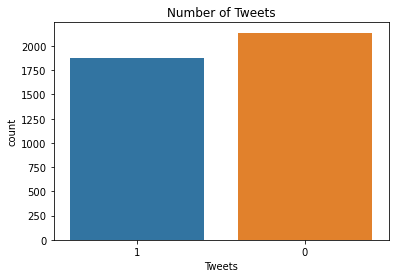

In [22]:
sns.countplot(data.Label)
plt.xlabel('Tweets')
plt.title('Number of Tweets')

In [23]:
print(len(data))

4009


In [24]:
# Data Preprocessing

In [25]:
def clean_text(text):
    text = text.lower()
    
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)        
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text) 
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

In [26]:
def CleanTokenize(df):
    tweets = list()
    lines = data["Body"].values.tolist()
    
    for line in lines:
        if isinstance(line, str):
            line = clean_text(line)
        else:
            continue
        # tokenize the text
        tokens = word_tokenize(line)
        # remove puntuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove non alphabetic characters
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        # remove stop words
        words = [w for w in words if not w in stop_words]
        tweets.append(words)
    return tweets

def Tokenize(df):
    tweets = list()
    lines = data["Body"].values.tolist()
    
    for line in lines:
        if isinstance(line, str):
            # tokenize the text
            tokens = word_tokenize(line)
        else:
            continue

        tweets.append(tokens)
    return tweets

tweets = CleanTokenize(data)
#tweets = Tokenize(data)


(-0.5, 999.5, 499.5, -0.5)

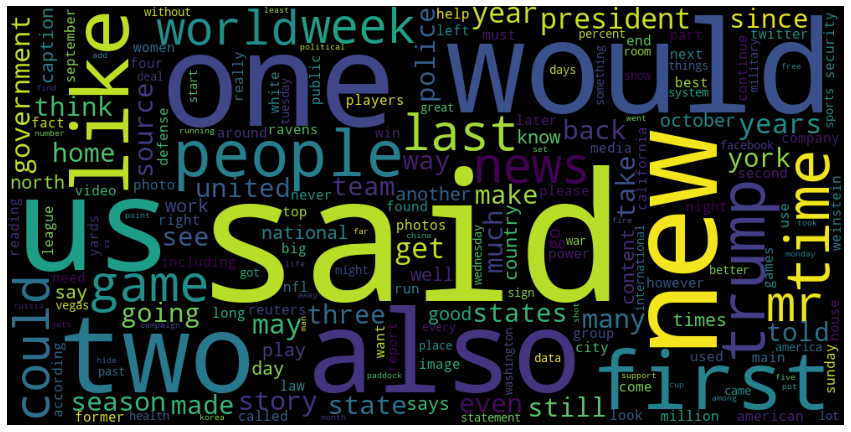

In [27]:
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator
pos_data = data.loc[data['Label'] == 1]
pos_head_lines = CleanTokenize(pos_data)
pos_lines = [j for sub in pos_head_lines for j in sub] 
word_could_dict=Counter(pos_lines)

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

In [28]:
validation_split = 0.2
max_length = 25


tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(tweets)
sequences = tokenizer_obj.texts_to_sequences(tweets)

word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)

lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
sentiment =  data['Label'].values

indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
sentiment = sentiment[indices]

le = LabelEncoder()
sentiment = le.fit_transform(sentiment)
# transfor from a array to a vector
sentiment = sentiment.reshape(-1,1)


num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]

X_test_pad = lines_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


unique tokens -  49054
vocab size - 49055


In [29]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (3208, 25)
Shape of y_train: (3208, 2)
Shape of X_test_pad: (801, 25)
Shape of y_test: (801, 2)


In [30]:
embeddings_index = {}

# Glove Stanford NLP 
f = open('glove.6B.300d.txt', encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))



Found 400000 word vectors.


In [31]:
embedding_dim = 300

embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
c = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        c+=1
        embedding_matrix[i] = embedding_vector

In [32]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

## LSTM Model

In [33]:
from tensorflow.keras import optimizers
def createModel(embedding_layer):
    model = Sequential()
    model.add(embedding_layer)
    model.add(LSTM(512, dropout=0.2, recurrent_dropout=0.50))
    model.add(Dense(2, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer = optimizers.RMSprop(learning_rate=1e-3), metrics=['acc'])
    return model

model = createModel(embedding_layer)
model.summary()

2022-03-23 02:47:52.278239: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 300)           14716500  
                                                                 
 lstm (LSTM)                 (None, 512)               1665024   
                                                                 
 dense (Dense)               (None, 2)                 1026      
                                                                 
Total params: 16,382,550
Trainable params: 1,666,050
Non-trainable params: 14,716,500
_________________________________________________________________


In [34]:
history = model.fit(X_train_pad, y_train, batch_size=10, epochs=20, validation_data=(X_test_pad, y_test), verbose=2)

Epoch 1/20
321/321 - 122s - loss: 0.2524 - acc: 0.9002 - val_loss: 0.1705 - val_acc: 0.9463 - 122s/epoch - 379ms/step
Epoch 2/20
321/321 - 116s - loss: 0.1329 - acc: 0.9539 - val_loss: 0.1037 - val_acc: 0.9551 - 116s/epoch - 362ms/step
Epoch 3/20
321/321 - 116s - loss: 0.0790 - acc: 0.9738 - val_loss: 0.1101 - val_acc: 0.9700 - 116s/epoch - 361ms/step
Epoch 4/20
321/321 - 117s - loss: 0.0566 - acc: 0.9841 - val_loss: 0.0926 - val_acc: 0.9750 - 117s/epoch - 363ms/step
Epoch 5/20
321/321 - 122s - loss: 0.0382 - acc: 0.9894 - val_loss: 0.1248 - val_acc: 0.9750 - 122s/epoch - 380ms/step
Epoch 6/20
321/321 - 114s - loss: 0.0305 - acc: 0.9916 - val_loss: 0.0986 - val_acc: 0.9775 - 114s/epoch - 354ms/step
Epoch 7/20
321/321 - 115s - loss: 0.0271 - acc: 0.9944 - val_loss: 0.1767 - val_acc: 0.9526 - 115s/epoch - 359ms/step
Epoch 8/20
321/321 - 117s - loss: 0.0157 - acc: 0.9963 - val_loss: 0.0866 - val_acc: 0.9825 - 117s/epoch - 363ms/step
Epoch 9/20
321/321 - 118s - loss: 0.0141 - acc: 0.9972 -

In [35]:
results = model.evaluate(X_test_pad, y_test, batch_size=32)

26/26 [==============================] - 3s 109ms/step - loss: 0.1192 - acc: 0.9800


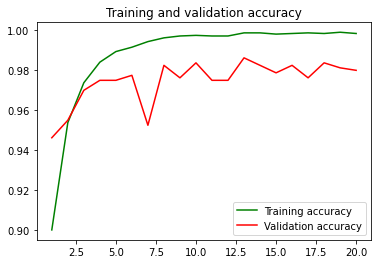

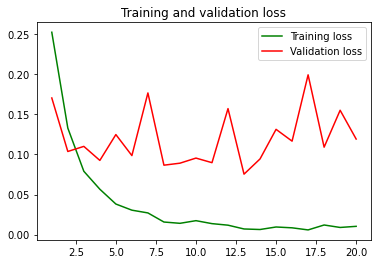

In [36]:
# Plot results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [38]:
import random
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import KFold
# KFold cross-validation
kFold = 10
scores = []
validation_split = 0.1
max_length = 25
results = []
train_res =[]
print("LSTM with Glove.6B.300d: ")
for i in range(kFold):
    print("Fold: ", i+1)
    prediction_val = []
    Y_test = []
    scores=[]
    random_shuff = random.randint(1, 7000)
    X_train_pad, X_test_pad, y_train, y_test = train_test_split(lines_pad, to_categorical(sentiment), test_size=0.10, shuffle = True, random_state=random_shuff)
    model = createModel(embedding_layer)
    history = model.fit(X_train_pad, y_train, batch_size=32, epochs=6, validation_data=(X_test_pad, y_test), verbose=1)
    
    print("Results for current fold:")
    print("Evaluation on training data")
    train_res.append(model.evaluate(X_train_pad, y_train, batch_size=128))
    
    print("Evaluation on testing data")
    results.append(model.evaluate(X_test_pad, y_test, batch_size=128))
    
    y_pred = model.predict(X_test_pad)
    for p in y_pred:
        prediction_val.append(np.argmax(p))
    for t in y_test:
        Y_test.append(np.argmax(t))
    scoreValue = accuracy_score(Y_test,prediction_val)
    scores.append(scoreValue)

LSTM with Glove.6B.300d: 
Fold:  1
Epoch 1/6
113/113 [==============================] - 78s 667ms/step - loss: 0.2676 - acc: 0.8955 - val_loss: 0.1119 - val_acc: 0.9651
Epoch 2/6
113/113 [==============================] - 58s 513ms/step - loss: 0.1315 - acc: 0.9532 - val_loss: 0.0924 - val_acc: 0.9701
Epoch 3/6
113/113 [==============================] - 58s 510ms/step - loss: 0.0800 - acc: 0.9759 - val_loss: 0.0652 - val_acc: 0.9751
Epoch 4/6
113/113 [==============================] - 57s 507ms/step - loss: 0.0616 - acc: 0.9781 - val_loss: 0.0635 - val_acc: 0.9751
Epoch 5/6
113/113 [==============================] - 58s 514ms/step - loss: 0.0409 - acc: 0.9859 - val_loss: 0.0502 - val_acc: 0.9875
Epoch 6/6
113/113 [==============================] - 60s 528ms/step - loss: 0.0270 - acc: 0.9917 - val_loss: 0.0500 - val_acc: 0.9900
Results for current fold:
Evaluation on training data
29/29 [==============================] - 6s 197ms/step - loss: 0.0103 - acc: 0.9978
Evaluation on testing d

113/113 [==============================] - 60s 531ms/step - loss: 0.0286 - acc: 0.9914 - val_loss: 0.1097 - val_acc: 0.9726
Results for current fold:
Evaluation on training data
29/29 [==============================] - 6s 196ms/step - loss: 0.0116 - acc: 0.9975
Evaluation on testing data
4/4 [==============================] - 1s 157ms/step - loss: 0.1097 - acc: 0.9726
Fold:  9
Epoch 1/6
113/113 [==============================] - 64s 546ms/step - loss: 0.2552 - acc: 0.9024 - val_loss: 0.1627 - val_acc: 0.9377
Epoch 2/6
113/113 [==============================] - 60s 527ms/step - loss: 0.1214 - acc: 0.9595 - val_loss: 0.1303 - val_acc: 0.9551
Epoch 3/6
113/113 [==============================] - 58s 513ms/step - loss: 0.0835 - acc: 0.9737 - val_loss: 0.0871 - val_acc: 0.9676
Epoch 4/6
113/113 [==============================] - 59s 519ms/step - loss: 0.0623 - acc: 0.9775 - val_loss: 0.0720 - val_acc: 0.9776
Epoch 5/6
113/113 [==============================] - 59s 519ms/step - loss: 0.0440 -

In [39]:
import statistics 

# mean_scores = statistics.mean(scores)
# print("predicted value", mean_scores)
score = []
for i in results:
    score.append(i[1])
x = statistics.mean(score)
    
print("Kfold Mean: ", x)


Kfold Mean:  0.9723191976547241


In [40]:
results2 = confusion_matrix(Y_test,prediction_val)
print ('Confusion Matrix :')
print(results2) 
print ('Accuracy Score :',accuracy_score(Y_test,prediction_val))
print ('Report : ')
print (classification_report(Y_test,prediction_val))

Confusion Matrix :
[[213   4]
 [  9 175]]
Accuracy Score : 0.9675810473815462
Report : 
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       217
           1       0.98      0.95      0.96       184

    accuracy                           0.97       401
   macro avg       0.97      0.97      0.97       401
weighted avg       0.97      0.97      0.97       401

